<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/ASI1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google. colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnaschavan","key":"3cffa9bc786519ab666d22ca9fe3c372"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet

 99% 1.02G/1.03G [00:10<00:00, 90.3MB/s]
100% 1.03G/1.03G [00:10<00:00, 106MB/s] 


In [5]:
!kaggle datasets download -d ayuraj/asl-dataset

 72% 41.0M/56.9M [00:00<00:00, 73.4MB/s]
100% 56.9M/56.9M [00:00<00:00, 89.1MB/s]


In [6]:
!pip install split-folders

In [7]:
import zipfile
zip_r = zipfile.ZipFile('/content/asl-alphabet.zip')
zip_r.extractall()
zip_r.close()

In [8]:
zip_r = zipfile.ZipFile('/content/asl-dataset.zip')
zip_r.extractall()
zip_r.close()

In [9]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

In [80]:
categories = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
    25: "Z"
}

In [38]:
base_path = "/content/asl_alphabet_train/asl_alphabet_train/"
filenames_list = []
categories_list = []
for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

def add_class_name_prefix(df, col_name):
    def prefix_filename(x):
        underscore_search = re.search("_", x)
        if underscore_search:  # Check if underscore was found
            underscore_pos = underscore_search.start()
            return x[underscore_pos + 1 : underscore_pos + 2] + "/" + x
        return x  # If no underscore found, return the original filename

    df[col_name] = df[col_name].apply(prefix_filename)
    return df

In [ ]:
# def add_class_name_prefix(df, col_name):
#     df[col_name] = df[col_name].apply(
#         lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
#         + "/"
#         + x
#     )
#     return df
df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [81]:
filenames_list = []
categories_list = []

# def add_class_name_prefix(df, col_name):
#     def prefix_filename(x):
#         underscore_search = re.search("_", x)
#         if underscore_search:  # Check if underscore was found
#             underscore_pos = underscore_search.start()
#             return x[underscore_pos + 1 : underscore_pos + 2] + "/" + x
#         return x  # If no underscore found, return the original filename

#     modified_paths = df[col_name].apply(prefix_filename)
#     df[col_name] = modified_paths
#     return df
def add_class_name_prefix(df, col_name):
  df[col_name] = df[col_name].apply(
      lambda x: x[0]
      + "/"
      + x
  )
  return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [82]:
df

,filename,category
0,Q/Q2069.jpg,16
1,V/V1052.jpg,21
2,O/O837.jpg,14
3,Q/Q270.jpg,16
4,O/O2051.jpg,14
...,...,...
77995,O/O825.jpg,14
77996,H/H2569.jpg,7
77997,Y/Y1378.jpg,24
77998,B/B1222.jpg,1


In [83]:
len(categories_list)

78000

In [ ]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = base_path + df.filename[i]
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

In [85]:
base_path+df.filename[1]

'/content/asl_alphabet_train/asl_alphabet_train/V/V1052.jpg'

In [86]:
print("number of elements = ", len(df))

number of elements =  78000


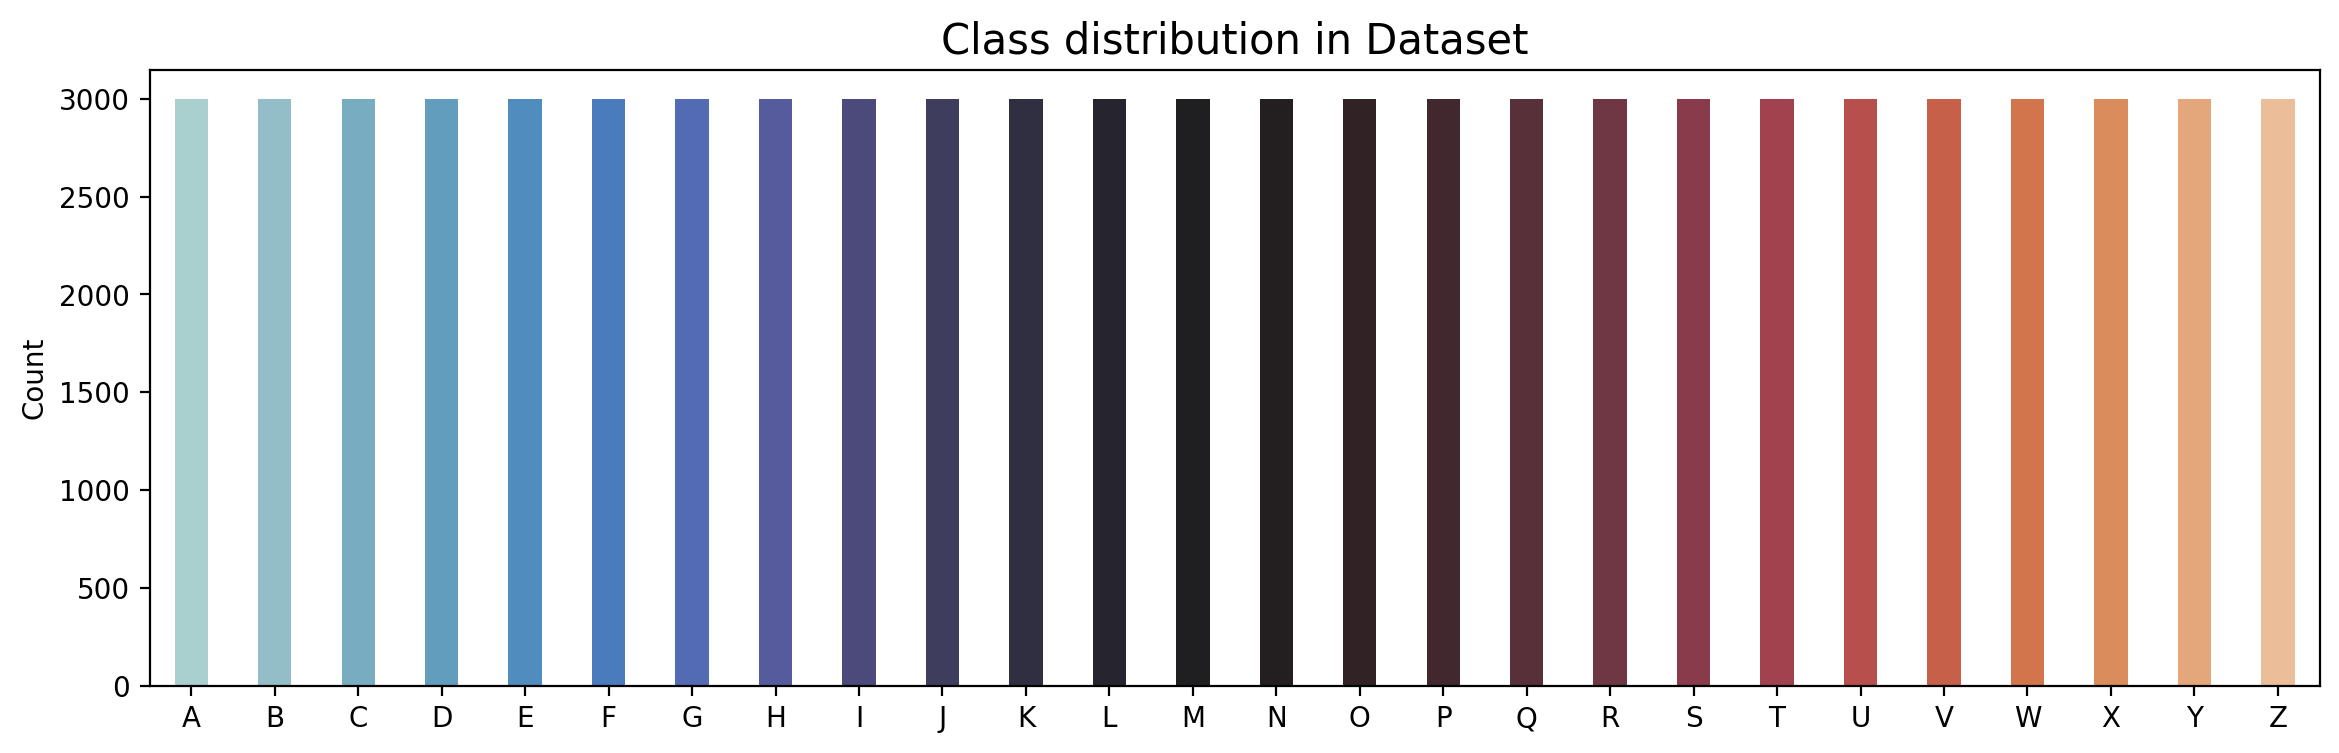

In [87]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

In [126]:
splitfolders.ratio('/content/asl_alphabet_train/asl_alphabet_train',output='/content/working/', seed=42, ratio=(0.8,0.1,0.1))

Copying files: 78000 files [00:41, 1890.77 files/s]


In [94]:
import shutil
shutil.rmtree("/content/working/train")
shutil.rmtree("/content/working/val")
shutil.rmtree("/content/working/test")

In [121]:
!ls /content/working/train

A  B  C  D  E  F  G  H	I  J  K  L  M  N  O  P	Q  R  S  T  U  V  W  X	Y  Z


In [127]:
datagen_train = ImageDataGenerator(rescale= 1 / 255.)
datagen_test = ImageDataGenerator(rescale= 1 / 255.)
datagen_valid = ImageDataGenerator(rescale= 1 / 255.)

In [128]:
train_path = '/content/working/train'
val_path = '/content/working/val'
test_path = '/content/working/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 26

In [129]:
train_data = datagen_train.flow_from_directory(directory= train_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical')

val_data = datagen_test.flow_from_directory(directory= val_path,
                                       target_size=(image_size,image_size),
                                       batch_size = batch,
                                       class_mode='categorical',
                                       )

test_data = datagen_valid.flow_from_directory(directory= test_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical',
                                         shuffle= False)

Found 74880 images belonging to 27 classes.
Found 14742 images belonging to 27 classes.
Found 14924 images belonging to 27 classes.


In [113]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

# fully connected layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(27, activation='softmax'))



model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 64)      36928     
                                                      

In [114]:
early_stoping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [118]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [119]:
history = model.fit(val_data,
                      validation_data= val_data,
                      epochs=30,
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/30
244/244 [==============================] - 50s 191ms/step - loss: 3.2609 - accuracy: 0.0350 - val_loss: 3.2586 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 2/30
244/244 [==============================] - 46s 187ms/step - loss: 3.2615 - accuracy: 0.0306 - val_loss: 3.2590 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 3/30
 27/244 [==>...........................] - ETA: 31s - loss: 3.2565 - accuracy: 0.0289

KeyboardInterrupt: 

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

In [130]:
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

In [133]:
splitfolders.ratio('/content/asl_dataset/asl_dataset',output='/content/working1/', seed=42, ratio=(0.8,0.1,0.1))

Copying files: 2515 files [00:00, 6549.75 files/s]


In [136]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [137]:
train_path = '/content/working1/train'
val_path = '/content/working1/val'
test_path = '/content/working1/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

In [138]:
train_data = datagen.flow_from_directory(directory= train_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path,
                                       target_size=(image_size,image_size),
                                       batch_size = batch,
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical',
                                         shuffle= False)

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


In [139]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

# fully connected layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(36, activation='softmax'))



model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 100, 100, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 100, 100, 64)      36928     
                                                      

In [140]:
early_stoping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [141]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [142]:
history = model.fit(train_data,
                      validation_data= val_data,
                      epochs=30,
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/30
63/63 [==============================] - 22s 260ms/step - loss: 2.5676 - accuracy: 0.3042 - val_loss: 0.7727 - val_accuracy: 0.7610 - lr: 0.0010
Epoch 2/30
63/63 [==============================] - 10s 157ms/step - loss: 0.7636 - accuracy: 0.7649 - val_loss: 0.2535 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 3/30
63/63 [==============================] - 10s 155ms/step - loss: 0.3920 - accuracy: 0.8757 - val_loss: 0.2055 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 4/30
63/63 [==============================] - 10s 155ms/step - loss: 0.2372 - accuracy: 0.9165 - val_loss: 0.1409 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 5/30
63/63 [==============================] - 10s 164ms/step - loss: 0.1731 - accuracy: 0.9349 - val_loss: 0.1305 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 6/30
63/63 [==============================] - 10s 156ms/step - loss: 0.1434 - accuracy: 0.9533 - val_loss: 0.0789 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 7/30
63/63 [==============================] - 10s 152ms/st

In [143]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.75149035453796
The Loss of the model for training data is: 0.0073940809816122055
The accuracy of the model for validation data is: 98.80478382110596
The Loss of the model for validation data is: 0.05459453538060188


<Axes: >

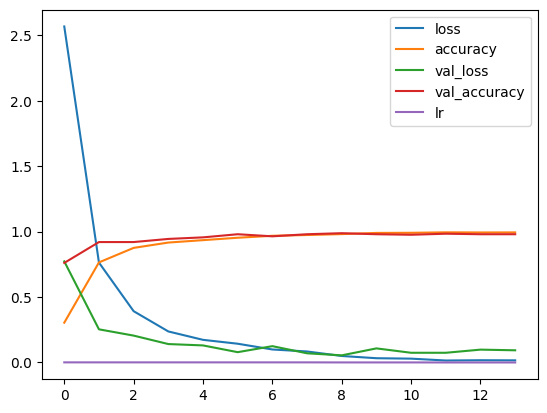

In [145]:
pd.DataFrame(history.history).plot()

In [146]:
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 99.60317611694336
The Loss of the model for testing data is: 0.038397423923015594


In [147]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 251
Incorrect predicted classes: 1


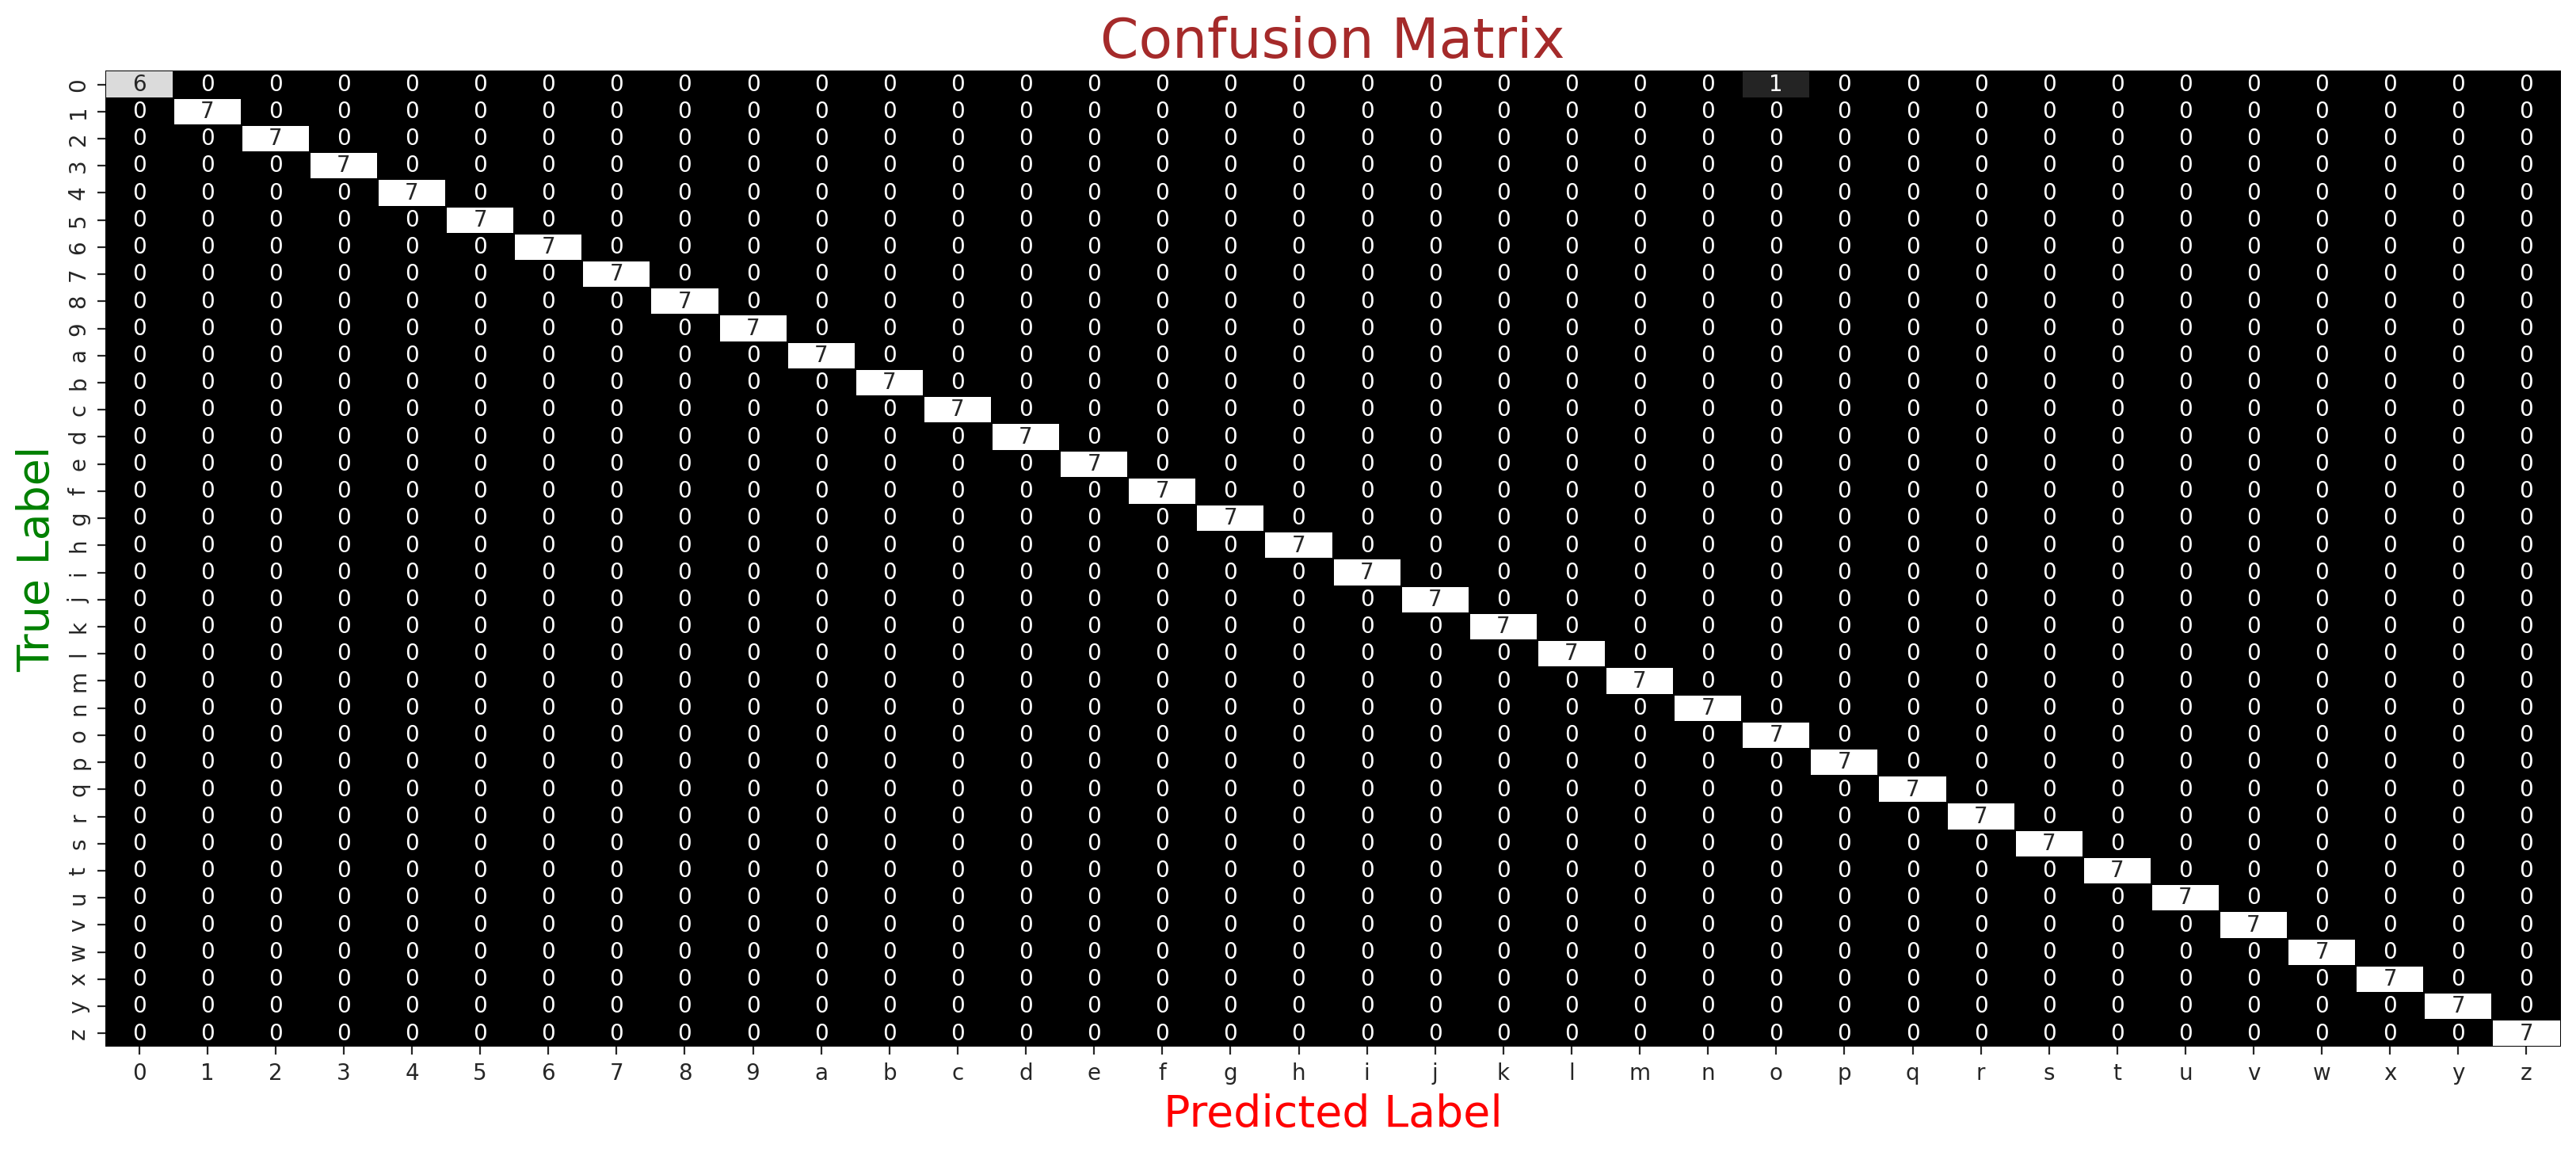

In [148]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax,
            cbar=False, xticklabels=categories.values(),
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

In [149]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [169]:
def load_and_prep_image(filename, img_shape=200):

  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [170]:
img = load_and_prep_image(ima)

In [181]:
model.predict(/content/working1/test/0/hand1_0_bot_seg_4_cropped.jpeg)

SyntaxError: invalid syntax (<ipython-input-181-a8f411de2195>, line 1)

In [216]:
ima = "/content/working/val/B/B1018.jpg"

In [217]:
img = load_and_prep_image(ima)

In [218]:
pred = model.predict(np.reshape(img,(-1,200,200,3)))

1/1 [==============================] - 0s 31ms/step


In [219]:
img.shape

TensorShape([200, 200, 3])

In [220]:
np.reshape(img,(-1,200,200,3)).shape

(1, 200, 200, 3)

In [221]:
np.argmax(pred)

34

In [222]:
categories[np.argmax(pred)]

'y'

In [ ]:
plt.imshow(img)